# Adversarial Examples

Let's start out by importing all the required libraries

In [1]:
import os
import sys

In [2]:
sys.path.append(os.path.join(os.getcwd(), "venv"))

In [3]:
import numpy as np

import torch
import torchvision.transforms as transforms

from matplotlib import pyplot as plt

from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

## MNIST 

Pytorch expects `Dataset` objects as input. Luckily, for MNIST (and few other datasets such as CIFAR and SVHN), torchvision has a ready made function to convert the dataset to a pytorch `Dataset` object. Keep in mind that these functions return `PIL` images so you will have to apply a transformation on them. 

In [4]:
path = os.path.join(os.getcwd(), "MNIST")
transform = transforms.Compose([transforms.ToTensor()])
train_mnist = MNIST(path, train=True, transform=transform)
test_mnist = MNIST(path, train=False, transform=transform)

### Visualize Dataset

Set `batch_size` to 1 to visualize the dataset.

In [ ]:
batch_size = 1
train_set = DataLoader(train_mnist, batch_size=batch_size, shuffle=True)
test_set = DataLoader(test_mnist, batch_size=batch_size, shuffle=True)

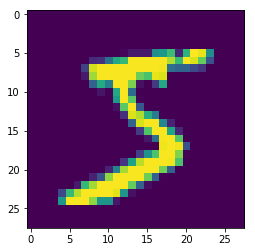

label: 
 5
[torch.LongTensor of size 1]



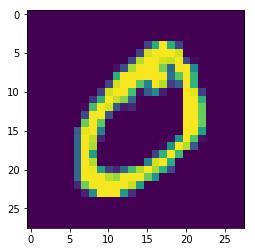

label: 
 0
[torch.LongTensor of size 1]



In [6]:
num_images = 2

for i, (image, label) in enumerate(train_set):
    if i == num_images:
        break
    #Pytorch returns batch_size x num_channels x 28 x 28
    plt.imshow(image[0][0])
    plt.show()
    print("label: " + str(label))

### Train a Model

Set `batch_size` to start training a model on the dataset.

In [7]:
batch_size = 64
train_set = DataLoader(train_mnist, batch_size=batch_size, shuffle=True)

Define a `SimpleCNN` model to train on MNIST

In [27]:
def identity():
    return lambda x: x


class CustomConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 activation, stride):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, kernel_size-2)
        self.activation = activation

    def forward(self, x):
        h = self.conv(x)
        return self.activation(h)

    
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=1, out_base=2, kernel_size=3, activation=identity(),
                 stride=2, num_classes=10):
        super().__init__()

        self.conv1 = CustomConv2D(in_channels, out_base, kernel_size, activation, stride)
        self.pool1 = nn.MaxPool2d((2, 2))

        self.conv2 = CustomConv2D(out_base, out_base, kernel_size, activation, stride)
        self.pool2 = nn.MaxPool2d((2, 2))

        self.linear = nn.Linear(4 * out_base, num_classes, bias=True)

        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        h = self.conv1(x)
        h = self.pool1(h)
        h = self.conv2(h)
        h = self.pool2(h)
        h = h.view([x.size(0), -1])
        return self.log_softmax(self.linear(h))


Create 4 model variations:

    identity_model: SimpleCNN model with identity activation functions
    relu_model: SimpleCNN model with relu activation functions
    sig_model: SimpleCNN model with sigmoid activation functions
    tanh_model: SimpleCNN model with tanh activation functions

In [28]:
identity_model = SimpleCNN()
relu_model = SimpleCNN(activation=nn.ReLU())
sig_model = SimpleCNN(activation=nn.Sigmoid())
tanh_model = SimpleCNN(activation=nn.Tanh())

Create a function to train the model

In [29]:
def train_model(model, train_set, num_epochs):
    optimizer = torch.optim.Adam(lr=0.001, params=model.parameters())
    for epoch in range(num_epochs):
        epoch_accuracy, epoch_loss = 0, 0
        train_set_size = 0
        for images, labels in train_set:
            batch_size = images.size(0)
            images_var, labels_var = Variable(images), Variable(labels)
            
            log_probs = model(images_var)
            _, preds = torch.max(log_probs, dim=-1)
            
            loss = nn.NLLLoss()(log_probs, labels_var)
            epoch_loss += loss.data.numpy()[0] * batch_size
            
            accuracy = preds.eq(labels_var).float().mean().data.numpy()[0] * 100.0
            epoch_accuracy += accuracy * batch_size
            train_set_size += batch_size
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_accuracy = epoch_accuracy / train_set_size
        epoch_loss = epoch_loss / train_set_size
        print("epoch {}: loss= {:.3}, accuracy= {:.4}".format(epoch + 1, epoch_loss, epoch_accuracy))
        
    return model
            

In [30]:
trained_model = train_model(relu_model, train_set, 10)

epoch 1: loss= 1.86, accuracy= 35.7
epoch 2: loss= 1.49, accuracy= 49.69
epoch 3: loss= 1.44, accuracy= 51.29
epoch 4: loss= 1.4, accuracy= 52.41
epoch 5: loss= 1.37, accuracy= 53.35
epoch 6: loss= 1.34, accuracy= 54.23
epoch 7: loss= 1.32, accuracy= 54.97
epoch 8: loss= 1.3, accuracy= 55.83
epoch 9: loss= 1.29, accuracy= 56.24
epoch 10: loss= 1.28, accuracy= 56.8


## Generating Adversarial Examples

Now that we have a trained model, we can generate adversarial examples.

### Gradient Ascent 

Use Gradient Ascent to generate a targeted adversarial example.

In [32]:
def np_val(torch_var):
    return torch_var.data.numpy()[0]


class AttackNet(nn.Module):
    def __init__(self, model, image_size):
        super().__init__()
        self.model = model
        self.params = nn.Parameter(torch.zeros(image_size), requires_grad=True)

    def forward(self, image):
        # clamp parameters here? or in backward?
        x = image + self.params
        x = torch.clamp(x, 0, 1)
        log_probs = self.model(x)
        return log_probs


class GradientAscent(object):
    def __init__(self, model, confidence=0):
        super().__init__()
        self.model = model
        self.num_steps = 10000
        self.confidence = confidence

    def attack(self, image, label, target=None):
        image_var = Variable(image)
        attack_net = AttackNet(self.model, image.shape)
        optimizer = torch.optim.Adam(lr=0.01, params=[attack_net.params])
        target = Variable(torch.from_numpy(np.array([target], dtype=np.int64))
                          ) if target is not None else None
        log_probs = attack_net(image_var)
        confidence, predictions = torch.max(torch.exp(log_probs), dim=-1)
        if label.numpy()[0] != np_val(predictions):
            print("model prediction does not match label")
            return None, (None, None), (None, None)
        else:
            for step in range(self.num_steps):
                stop_training = self.perturb(image_var, attack_net, target, optimizer)
                if stop_training:
                    print("Adversarial attack succeeded after {} steps!".format(
                        step + 1))
                    break
            if stop_training is False:
                print("Adversarial attack failed")

        log_probs = attack_net(image_var)
        adv_confidence, adv_predictions = torch.max(torch.exp(log_probs), dim=-1)
        return attack_net.params, (confidence, predictions), (adv_confidence,
                                                              adv_predictions)

    def perturb(self, image, attack_net, target, optimizer):
        log_probs = attack_net(image)
        confidence, predictions = torch.max(torch.exp(log_probs), dim=-1)

        if (np_val(predictions) == np_val(target) and
                    np_val(confidence) >= self.confidence):
            return True

        loss = nn.NLLLoss()(log_probs, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return False

Define a `GradientAscent` object

In [33]:
gradient_ascent = GradientAscent(trained_model)

Define a function to help plot the results

In [34]:
%matplotlib inline

def plot_results(image, perturbation, orig_pred, orig_con, adv_pred, adv_con):
    plot_image = image.numpy()[0][0]
    plot_perturbation = perturbation.data.numpy()[0][0]
    
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 5
    plt.rcParams["figure.figsize"] = fig_size
    
    ax = plt.subplot(131)
    ax.set_title("Original: " + str(np_val(orig_pred)) + " @ " +
                 str(np.round(np_val(orig_con) * 100, decimals=1)) + "%")
    plt.imshow(plot_image)
    plt.subplot(132)
    plt.imshow(plot_perturbation)
    ax = plt.subplot(133)
    plt.imshow(plot_image + plot_perturbation)
    ax.set_title("Adversarial: " + str(np_val(adv_pred)) + " @ " +
                 str(np.round(np_val(adv_con) * 100, decimals=1)) + "%")
    plt.show()

Let's generate some adversarial examples!

Adversarial attack succeeded after 3 steps!


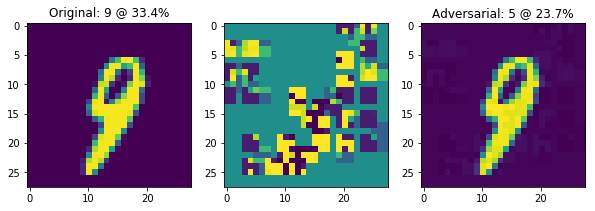

Adversarial attack succeeded after 21 steps!


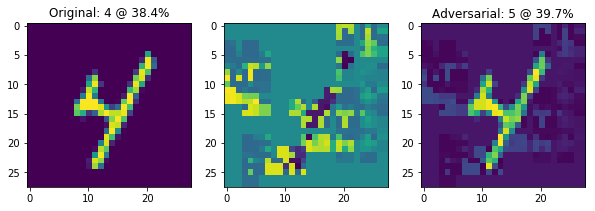

In [36]:
num_images = 2

for i, (test_image, test_label) in enumerate(test_set):
    if i == num_images:
        break
    target_classes = list(range(10))
    target_classes.remove(test_label.numpy()[0])
    target = np.random.choice(target_classes)
    perturbation, (orig_con, orig_pred), (
        adv_con, adv_pred) = gradient_ascent.attack(test_image, test_label, target)
    if perturbation is not None:
        plot_results(test_image, perturbation, orig_pred, orig_con, adv_pred, adv_con)

### Fast Gradient

Now let's use the Fast Gradient Sign Method to generate untargeted adversarial examples.

In [37]:
class FastGradient(object):
    def __init__(self, model, confidence=0, alpha=0.1):
        super().__init__()
        self.model = model
        self.confidence = confidence
        self.alpha = alpha

    def attack(self, image, label):
        image_var = Variable(image, requires_grad=True)
        target = Variable(torch.from_numpy(np.array([label], dtype=np.int64))
                          ) if label is not None else None
        log_probs = self.model(image_var)
        confidence, predictions = torch.max(torch.exp(log_probs), dim=-1)
        if label.numpy()[0] != np_val(predictions):
            print("model prediction does not match label")
            return None, (None, None), (None, None)
        else:
            loss = nn.NLLLoss()(log_probs, target)
            loss.backward()
            
            x_grad = torch.sign(image_var.grad.data)
            adv_image = torch.clamp(image_var.data + self.alpha * x_grad, 0, 1)
            delta = adv_image - image_var.data

            adv_log_probs = self.model(Variable(adv_image))
            adv_confidence, adv_predictions = torch.max(torch.exp(adv_log_probs),
                                                        dim=-1)
            if (np_val(adv_predictions) != np_val(predictions) and
                        np_val(adv_confidence) >= self.confidence):
                print("Adversarial attack succeeded!")
            else:
                print("Adversarial attack failed")
                
        return Variable(delta), (confidence, predictions), (adv_confidence,
                                                               adv_predictions)

Define a `FastGradient` object

In [38]:
fast_gradient = FastGradient(trained_model)

Let's generate some adversarial examples!

Adversarial attack failed


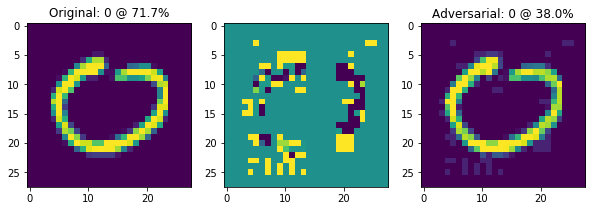

Adversarial attack succeeded!


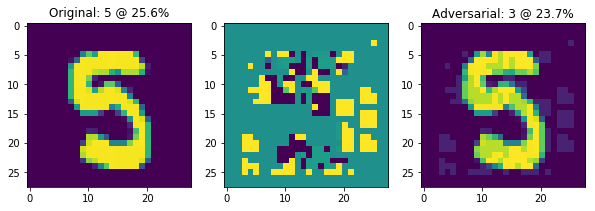

Adversarial attack succeeded!


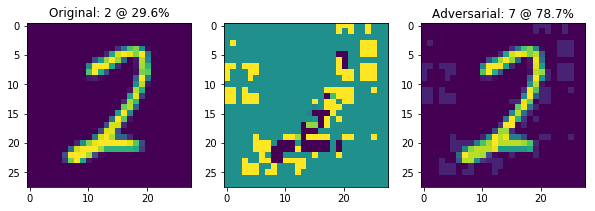

Adversarial attack succeeded!


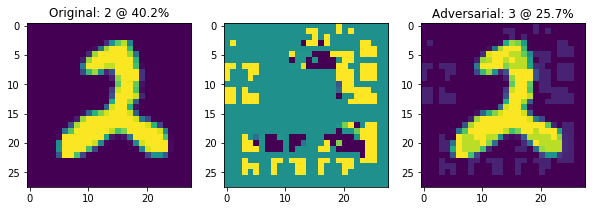

Adversarial attack succeeded!


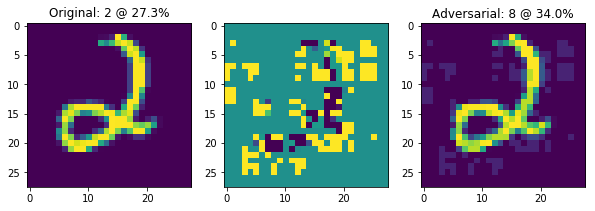

model prediction does not match label
Adversarial attack succeeded!


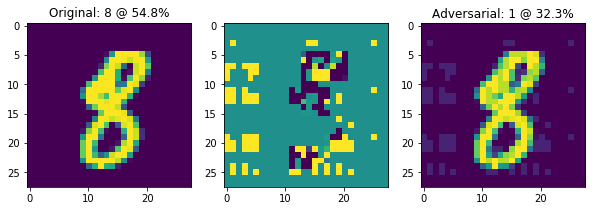

model prediction does not match label
model prediction does not match label
Adversarial attack succeeded!


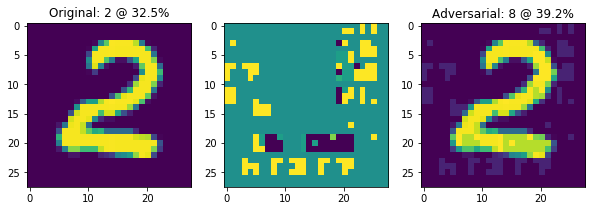

Adversarial attack succeeded!


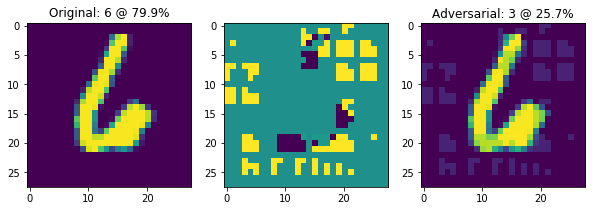

model prediction does not match label
Adversarial attack succeeded!


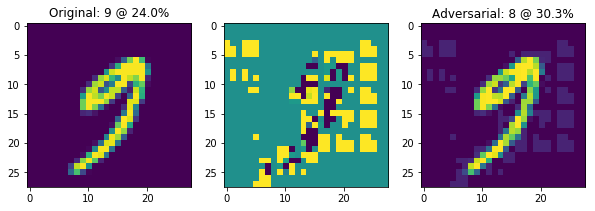

Adversarial attack succeeded!


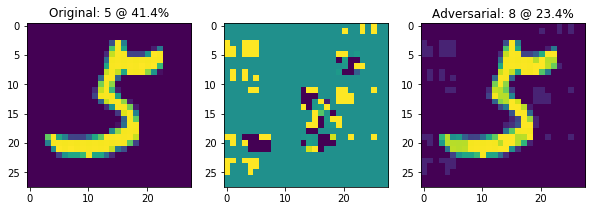

model prediction does not match label
model prediction does not match label
Adversarial attack succeeded!


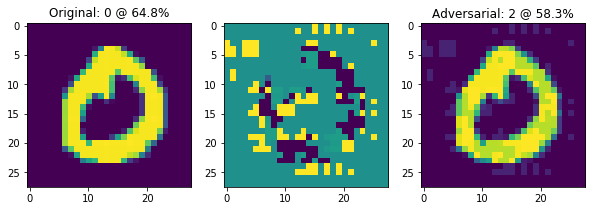

model prediction does not match label
model prediction does not match label
model prediction does not match label


In [39]:
num_images = 20

for i, (test_image, test_label) in enumerate(test_set):
    if i == num_images:
        break
    perturbation, (orig_con, orig_pred), (
        adv_con, adv_pred) = fast_gradient.attack(test_image, test_label)
    if perturbation is not None:
        plot_results(test_image, perturbation, orig_pred, orig_con, adv_pred, adv_con)